### Local Variance Estimation

When working with time series (observations of a natural sequential ordering) one often wishes to estimate the variance of the time series locally. This notebook will go over a collection of methods that can be utilized to create an estimator for the local variance (or volatility) function

In [1]:

import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")


PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)
DATA_FILE = "AMZN_reconstructed_features.csv"


In [2]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0, nrows=10000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


In [3]:

regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,YearMonth,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


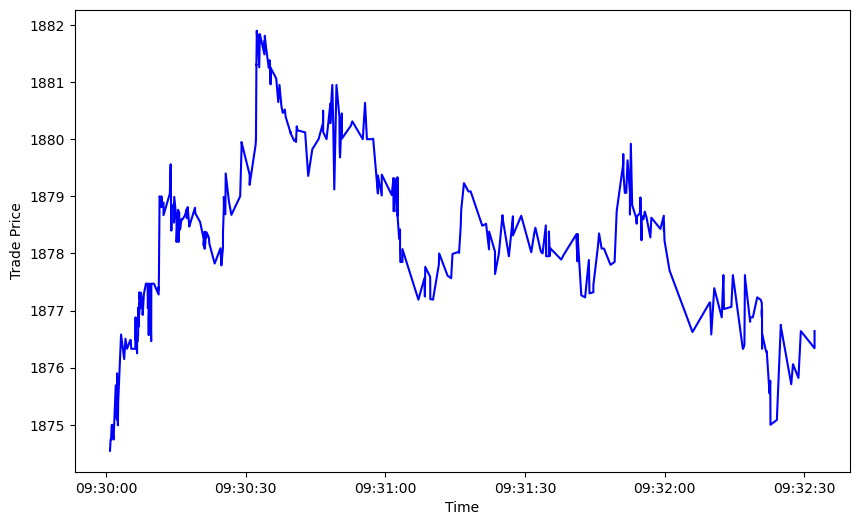

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, regular_trades["Trade_Price"], color="blue", label="Trade Price")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Price")

plt.show()


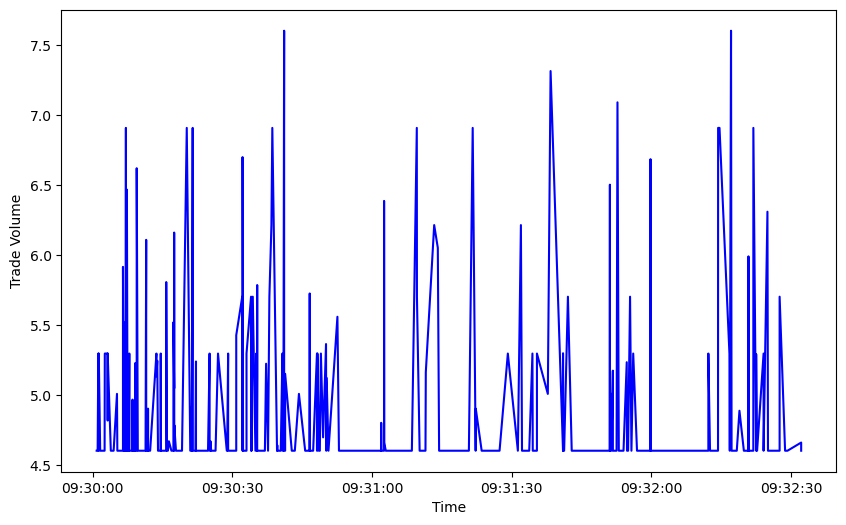

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(regular_trades.index, np.log(regular_trades["Trade_Volume"]), color="blue", label="Trade Volume")

ax.set_xlabel("Time")
ax.set_ylabel("Trade Volume")

plt.show()


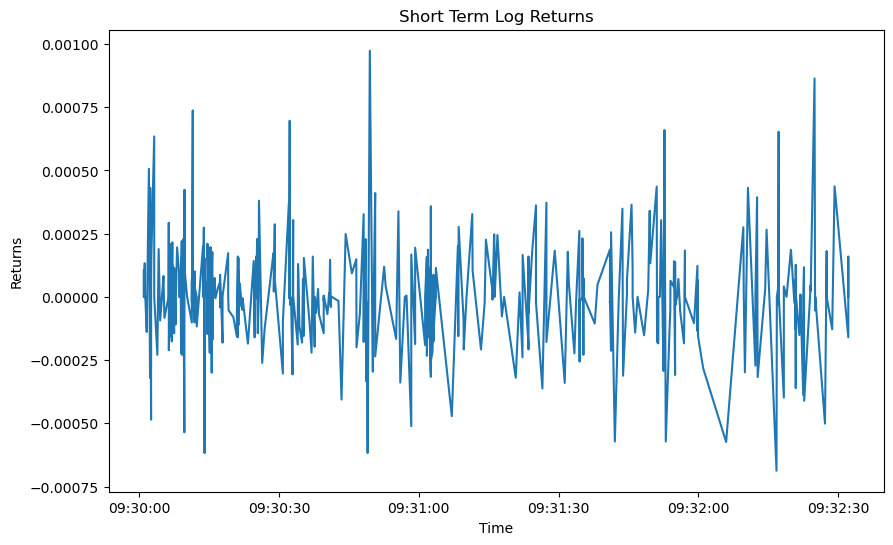

In [6]:
returns= np.log(regular_trades["Trade_Price"][1:].values/regular_trades["Trade_Price"][:-1].values)

returns=pd.Series(returns, index=regular_trades.index[1:])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(returns)
ax.set_title("Short Term Log Returns")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
plt.show()


### Local Variance Estimators

Assuming that $E[r_t] = 0$ for all $t$, the local variance of a time series $r_t$ is defined as

$$\sigma^2_t = \frac{1}{T}\sum_{i=1}^T r_i^2$$

where $T$ is the window size. This is the most basic estimator of the local variance, and is often referred to as the "naive" estimator. It is also known as the "sample variance" estimator. The sample variance estimator is unbiased, but has high variance. This is because the variance of the sample mean is proportional to $1/T$, and the variance of the sample variance is proportional to $1/T^2$. This means that the variance of the sample variance is proportional to $1/T$, which is why the sample variance estimator has high variance.

In [7]:
def sample_variance(returns, T):

    def compute_sample_variance(x):
        return (x**2).sum() / (T )
    return returns.rolling(T).apply(lambda x: compute_sample_variance(x))

In [8]:
naive_variance = sample_variance(returns, 25).dropna()

padded_variance=np.pad(naive_variance, (25,0),mode='mean')/naive_variance[0]




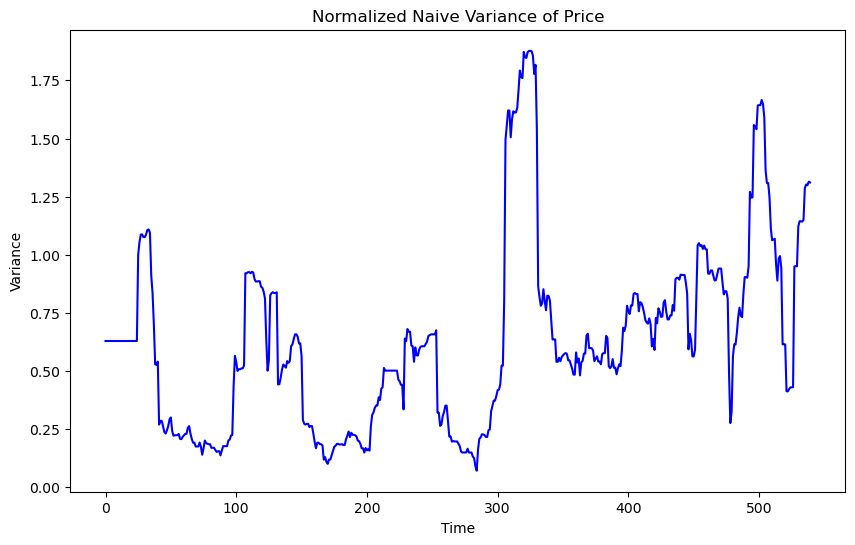

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(padded_variance, color="blue", label="Naive Variance")
ax.set_title("Normalized Naive Variance of Price")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()


### Regression Trees

Decision Trees / Regression Trees are great models for generating piecewise constant estimates. They are also very easy to implement. The downside is that they are not very flexible, and can only generate piecewise constant estimates. This is a problem because the local variance is not piecewise constant. However, we can use the regression tree to generate a coarse estimate of the local variance, and then use this as an adaptive filter when trend filtering the time series.

In [10]:
from sklearn import tree


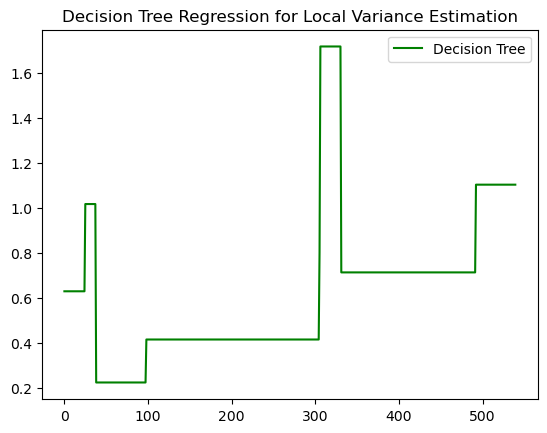

In [11]:
model=tree.DecisionTreeRegressor(max_depth=3)

model.fit(np.arange(len(padded_variance)).reshape(-1,1),  padded_variance)

predictions=model.predict(np.arange(len( padded_variance)).reshape(-1,1))

plt.title("Decision Tree Regression for Local Variance Estimation")

plt.plot(np.arange(len( padded_variance)), predictions, color="green", label="Decision Tree")

plt.legend()

### Effect of Price Variance on Trend Filtering

In [13]:
import sys
sys.path.append("../../")
from estimators.trend_filtering.trend_filter import Trend_Filter
from estimators.cv_base_estimator import cv_base_estimator

from estimators.regression.piecewise_polynomial import Piecewise_Polynomial_Model

In [15]:
trade_price=regular_trades["Trade_Price"].values

x=np.arange(len(trade_price))

tf=Trend_Filter(x,trade_price,k=1,method='primal_dual')

start_time = time.time()
cv_base_estimator(tf)

print("--- %s seconds ---" % (time.time() - start_time))


Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.7493122262110272
Performing cross validation for lambda = 3.3773931422533314
Performing cross validation for lambda = 6.520725269294369
Performing cross validation for lambda = 12.589549468098268
Performing cross validation for lambda = 24.306614565720647
Performing cross validation for lambda = 46.92872553887737
Performing cross validation for lambda = 90.60518381729598
Performing cross validation for lambda = 174.9312226211027
Performing cross validation for lambda = 337.73931422533315
Performing cross validation for lambda = 652.0725269294369
Performing cross validation for lambda = 1258.9549468098255
Performing cross validation for lambda = 2430.6614565720647
Performing cross validation for lambda = 4692.872553887737
Performing cross validation for lambda = 9060.51838172959
Performing cross validation for lambda = 17493.12226211027
Performing  1 out of 3 iterations of cross validation
P

In [16]:
regime_model=Piecewise_Polynomial_Model(x,tf.y_hat,k=1,method="continous_tf")

[ 20  90 113 186 238 301 362 379 424 438 484 523]
{1: [238], 2: [238, 438], 3: [301, 362, 438], 4: [113, 186, 238, 438], 5: [20, 113, 186, 238, 438], 6: [20, 113, 186, 238, 424, 438], 7: [20, 113, 186, 238, 379, 424, 438], 8: [20, 90, 113, 186, 238, 379, 424, 438], 9: [20, 90, 113, 186, 238, 379, 424, 438, 523], 10: [20, 90, 113, 186, 238, 362, 379, 424, 438, 523], 11: [20, 90, 113, 186, 238, 301, 362, 379, 424, 438, 523], 12: [20, 90, 113, 186, 238, 301, 362, 379, 424, 438, 484, 523], 0: []}
k: 0 mse: 2.0541922783984443
k: 1 mse: 0.7053990108523774
k: 2 mse: 0.592191966326699
k: 3 mse: 0.5152990779979625
k: 4 mse: 0.435325538667351
k: 5 mse: 0.3608591114456362
k: 6 mse: 0.2922202838453312
k: 7 mse: 0.23483537206537108
k: 8 mse: 0.18876963056982557
k: 9 mse: 0.16661086125551539
k: 10 mse: 0.16076596562220744
k: 11 mse: 0.14521347729627915
k: 12 mse: 0.1514636388076057


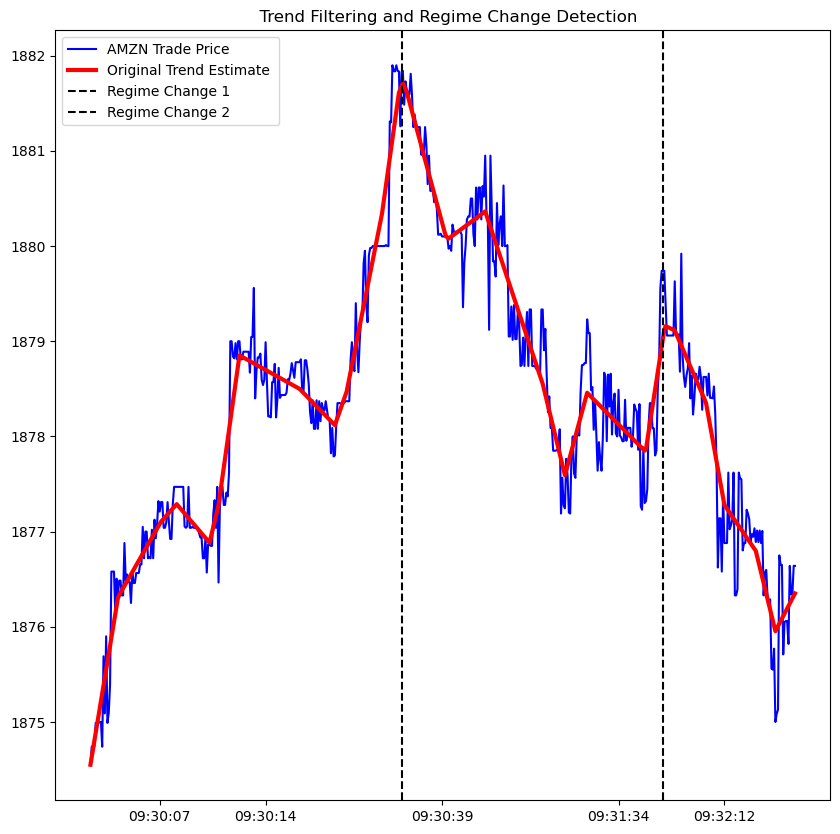

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(tf.y_hat, label="Original Trend Estimate ",color='red',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title("  Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Adaptive Trend Filtering

Here we pass in the reciprocal of the local variance as a weight to the trend filter. This is a very simple way to adaptively filter the time series. The intuition is that if the local variance is high, then the time series is more volatile, and we should be more conservative in our trend filtering. If the local variance is low, then the time series is less volatile, and we can be more aggressive in our trend filtering.

In [18]:
atf=Trend_Filter(x,trade_price,k=1,method="primal_dual",prior=1/predictions)

start_time = time.time()
cv_base_estimator(atf)

print("--- %s seconds ---" % (time.time() - start_time))

Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.775605888295147
Performing cross validation for lambda = 3.4281582559231656
Performing cross validation for lambda = 6.618737358963218
Performing cross validation for lambda = 12.778781187025016
Performing cross validation for lambda = 24.671963815685192
Performing cross validation for lambda = 47.63410450603311
Performing cross validation for lambda = 91.96705738718559
Performing cross validation for lambda = 177.5605888295147
Performing cross validation for lambda = 342.8158255923165
Performing cross validation for lambda = 661.8737358963218
Performing cross validation for lambda = 1277.8781187025002
Performing cross validation for lambda = 2467.1963815685194
Performing cross validation for lambda = 4763.410450603312
Performing cross validation for lambda = 9196.70573871855
Performing cross validation for lambda = 17756.05888295147
Performing  1 out of 3 iterations of cross validation
Per

In [19]:
regime_model=Piecewise_Polynomial_Model(x,atf.y_hat,k=1,method="continous_tf")

regime_model.knots

[ 25  98 118 187 238 273 306 361 422 446 523]
{1: [238], 2: [187, 238], 3: [238, 361, 446], 4: [187, 238, 361, 446], 5: [118, 187, 238, 361, 446], 6: [25, 118, 187, 238, 361, 446], 7: [25, 118, 187, 238, 361, 422, 446], 8: [25, 118, 187, 238, 306, 361, 422, 446], 9: [25, 98, 118, 187, 238, 306, 361, 422, 446], 10: [25, 98, 118, 187, 238, 306, 361, 422, 446, 523], 11: [25, 98, 118, 187, 238, 273, 306, 361, 422, 446, 523], 0: []}
k: 0 mse: 1.9889680192762769
k: 1 mse: 0.5783663988694946
k: 2 mse: 0.510121095574206
k: 3 mse: 0.3672583283209549
k: 4 mse: 0.2990130250256663
k: 5 mse: 0.20978833935931737
k: 6 mse: 0.15225808393577528
k: 7 mse: 0.12246536791660576
k: 8 mse: 0.0938055217561362
k: 9 mse: 0.0664679903962388
k: 10 mse: 0.04143823912877383
k: 11 mse: 0.01778339221080649


[238]

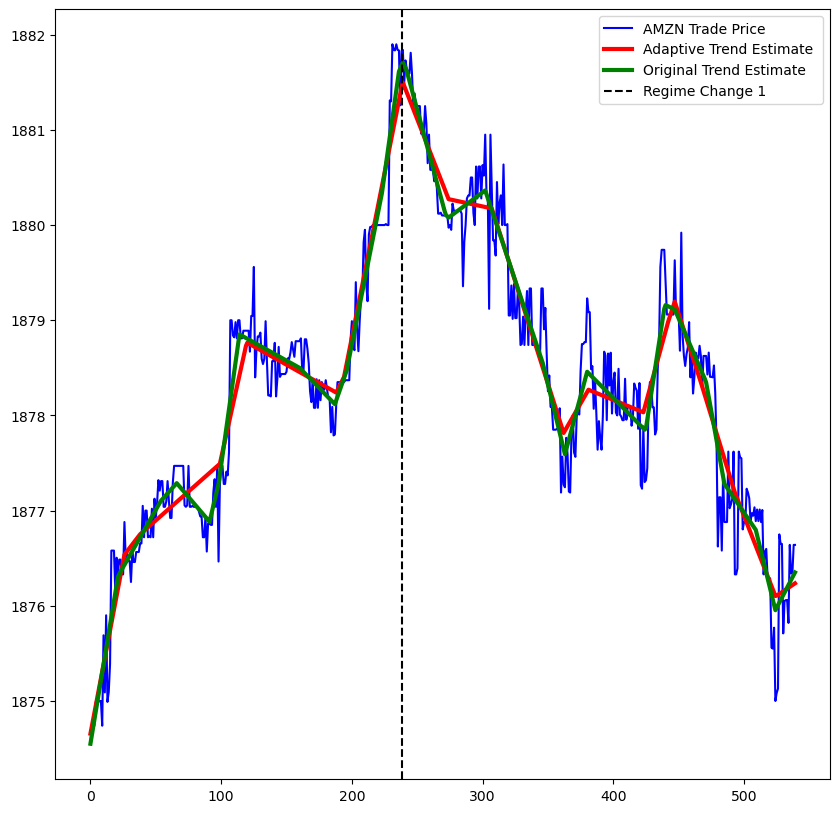

In [20]:
fig,    ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(atf.y_hat, label="Adaptive Trend Estimate ",color='red',lw=3)
ax.plot(tf.y_hat, label="Original Trend Estimate ",color='green',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()


### Adaptive Trend Filtering with Volume



Text(0, 0.5, 'Log of Trade Volume')

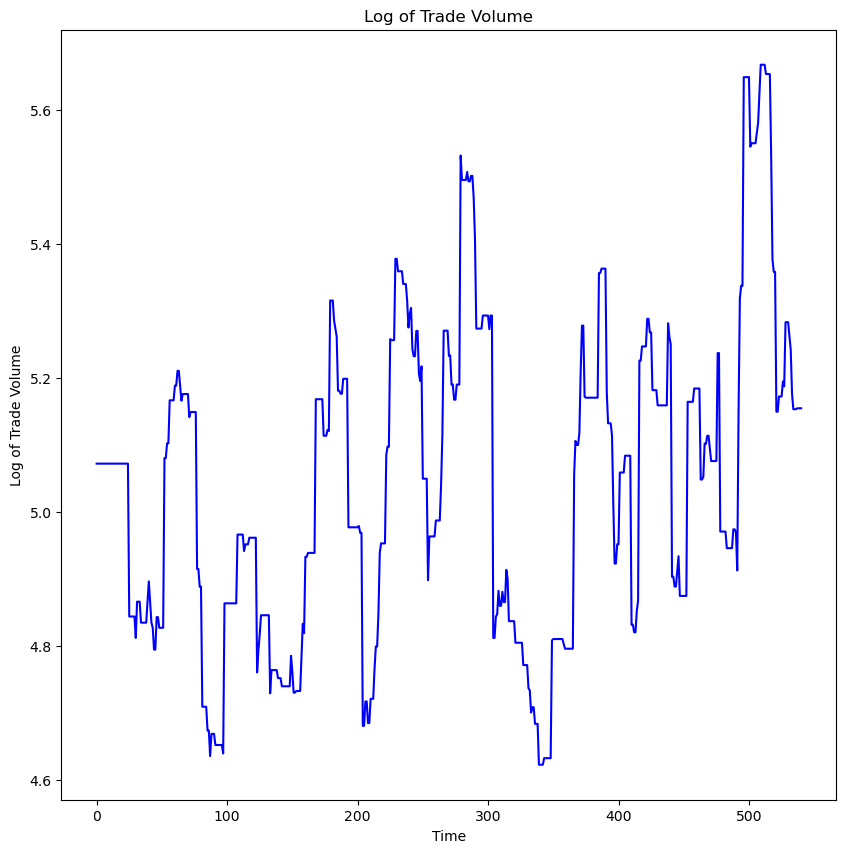

In [29]:
volume=regular_trades["Trade_Volume"].rolling(25).mean().dropna()

padded_volume=np.log(np.pad(volume, (25,0),mode='mean'))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(padded_volume, label="AMZN Trade Volume",color='blue')
ax.set_title("Log of Trade Volume")
ax.set_xlabel("Time")
ax.set_ylabel("Log of Trade Volume")


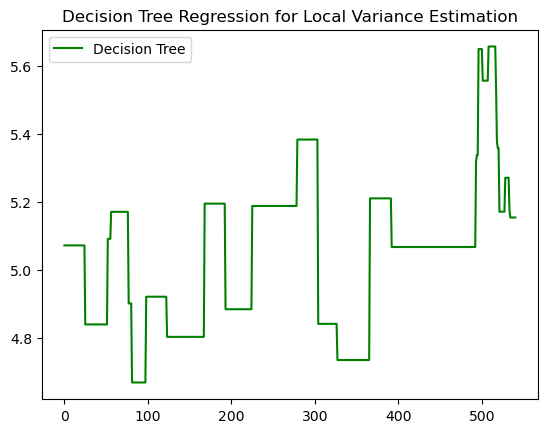

In [30]:
vol_tree=tree.DecisionTreeRegressor(max_depth=5)

vol_tree.fit(np.arange(len(padded_volume)).reshape(-1,1),  padded_volume)

predictions=vol_tree.predict(np.arange(len( padded_volume)).reshape(-1,1))

plt.title("Decision Tree Regression for Local Variance Estimation")

plt.plot(np.arange(len( padded_volume)), predictions, color="green", label="Decision Tree")

plt.legend()


In [34]:
vtf=Trend_Filter(x,trade_price,k=1,method="primal_dual",prior=1/predictions)

start_time = time.time()
cv_base_estimator(vtf)

print("--- %s seconds ---" % (time.time() - start_time))



Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 1.6878794696668113
Performing cross validation for lambda = 3.258785058714376
Performing cross validation for lambda = 6.291728911778513
Performing cross validation for lambda = 12.147426720719869
Performing cross validation for lambda = 23.453009181469547
Performing cross validation for lambda = 45.28067156214126
Performing cross validation for lambda = 87.42328974733456
Performing cross validation for lambda = 168.78794696668112
Performing cross validation for lambda = 325.8785058714376
Performing cross validation for lambda = 629.1728911778514
Performing cross validation for lambda = 1214.7426720719855
Performing cross validation for lambda = 2345.3009181469547
Performing cross validation for lambda = 4528.067156214126
Performing cross validation for lambda = 8742.328974733447
Performing cross validation for lambda = 16878.794696668112
Performing  1 out of 3 iterations of cross validation


In [32]:
regime_model=Piecewise_Polynomial_Model(x,vtf.y_hat,k=1,method="continous_tf")


[110 233 366 387 424 437 473 523]
{1: [233], 2: [233, 437], 3: [233, 424, 437], 4: [233, 424, 437, 523], 5: [233, 387, 424, 437, 523], 6: [233, 366, 387, 424, 437, 523], 7: [233, 366, 387, 424, 437, 473, 523], 8: [110, 233, 366, 387, 424, 437, 473, 523], 0: []}
k: 0 mse: 2.1042167837188095
k: 1 mse: 0.7530372988723537
k: 2 mse: 0.6524680096404232
k: 3 mse: 0.6033048845511988
k: 4 mse: 0.5703852809224843
k: 5 mse: 0.5496300058202147
k: 6 mse: 0.5591794380134515
k: 7 mse: 0.5726692547588004
k: 8 mse: 0.8041299562835161


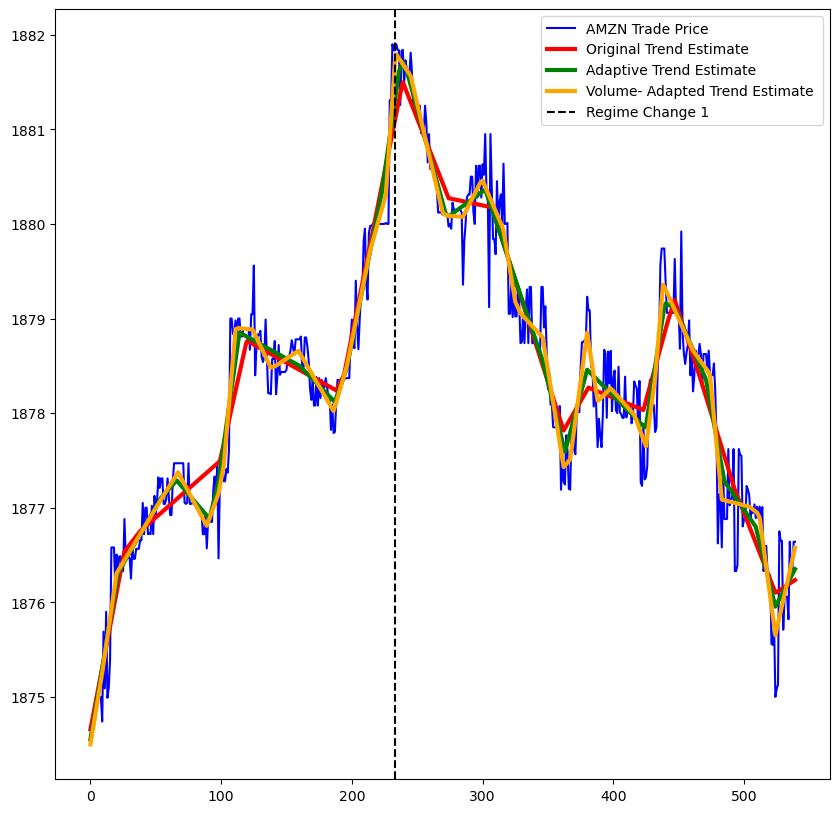

In [33]:
fig,    ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price, label="AMZN Trade Price",color='blue')
ax.plot(atf.y_hat, label="Original Trend Estimate ",color='red',lw=3)
ax.plot(tf.y_hat, label="Adaptive Trend Estimate ",color='green',lw=3)
ax.plot(vtf.y_hat, label="Volume- Adapted Trend Estimate ",color='orange',lw=3)

for i in range(len(regime_model.knots)):
    ax.axvline(regime_model.knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()